In [1]:
import nltk
import re
import os
from glob import glob
import pandas as pd

In [2]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph

In [3]:
from nltk.corpus.reader.dependency import DependencyCorpusReader

In [4]:
import tarfile

# What to do

1.	~~Arabic-NYUAD	629K~~
2.	~~Catalan	472K~~
3.	~~Czech	1,330K~~
4.	~~French	381K~~
5.	~~Hindi	316K~~
6.	~~Russian-SynTagRus	988K~~
7.	~~Spanish-AnCora	495K~~
8.	~~Latin-ITTB	280K~~
9.	~~Portuguese-BR	268K~~
10.	~~Norwegian-Bokmaal	280K~~
11.	~~German	277K~~

Starting Network:
lemmas only; keep punct/symbols; with deprel (labeled edges)

columns:
* lemma-head
* lemma-dep
* deprel
* count

# Extract tar for UD

In [28]:
lgs = ["Hindi", "Russian-SynTagRus", "Spanish-AnCora", "Latin-ITTB", "Portuguese-BR","Norwegian-Bokmaal"]

In [5]:
tar = tarfile.open("/Users/fmambrini/Downloads/Universal Dependencies 2.0/ud-treebanks-conll2017.tgz", "r:gz")

In [29]:
name = lgs[-1]
for tarinfo in tar:
    if name in tarinfo.name:
        print(tarinfo.name)

ud-treebanks-conll2017/UD_Norwegian-Bokmaal
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-dev.txt
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/stats.xml
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-dev.conllu
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-train.conllu
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/README.md
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/no_bokmaal-ud-train.txt
ud-treebanks-conll2017/UD_Norwegian-Bokmaal/LICENSE.txt


In [25]:
fold = os.path.join("ud-treebanks-conll2017", "UD_French")
subdir_and_files = [tarinfo for tarinfo in tar.getmembers() if tarinfo.name.startswith(fold)]

In [26]:
len(subdir_and_files)

22

The following line of code extracts the selected directory

In [30]:
tar.extractall(members=subdir_and_files)

In [31]:
for l in lgs:
    print("Working with", l)
    fold = os.path.join("ud-treebanks-conll2017", "UD_" + l)
    subdir_and_files = [tarinfo for tarinfo in tar.getmembers() if tarinfo.name.startswith(fold)]
    tar.extractall(members=subdir_and_files)

Working with Hindi
Working with Russian-SynTagRus
Working with Spanish-AnCora
Working with Latin-ITTB
Working with Portuguese-BR
Working with Norwegian-Bokmaal


Then, the next line could be useful to inspect the content

In [32]:
with open("ud-treebanks-conll2017/UD_German/de-ud-dev.conllu") as f:
    lines = f.readlines()

In [33]:
sent = lines[:10]
for s in sent: print(s)

# sent_id = dev-s1

# text = Manasse ist ein einzigartiger Parfümeur.

1	Manasse	Manasse	PROPN	NN	Case=Nom|Number=Sing	5	nsubj	_	_

2	ist	sein	VERB	VAFIN	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	5	cop	_	_

3	ein	ein	DET	ART	Definite=Ind|PronType=Art	5	det	_	_

4	einzigartiger	einzigartig	ADJ	ADJA	Degree=Cmp,Pos	5	amod	_	_

5	Parfümeur	Parfümeur	NOUN	NN	_	0	root	_	SpaceAfter=No

6	.	.	PUNCT	$.	_	5	punct	_	_



# sent_id = dev-s2



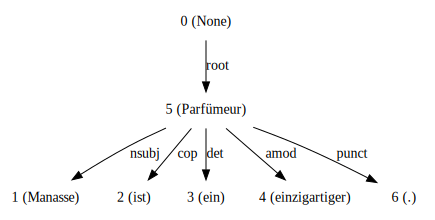

In [132]:
d = DependencyGraph(sent, top_relation_label="root")
d

# Load the corpus

In [17]:
r = "ud-treebanks-conll2017/UD_Czech/"

## Convert CoNLLu to CoNLLx

The DependencyCorpusReader doesn't work with CoNLLU: we need to convert everything to the old CoNLLX format

In [180]:
fs = glob(r + "*/*.conllu")

In [181]:
fs

[]

In [38]:
for f in fs:
    out = f.replace(".conllu", ".conllx")
    !perl conllu_to_conllx.pl {f} > {out}

## DependencyCorpusReader

The parsed_sents method has a small problem: it assumes "ROOT" as the top relation, yet at least some CoNLLU files have "root"; the all-caps version is what the DependencyGraph object loader expects as default, and there's no way to pass a different value to it. It is however pretty easy to overrite:

In [18]:
def fixed_parsed_sents(self, fileids=None, top_label="root"):
    from nltk.corpus.reader.util import concat
    from nltk.corpus.reader.dependency import DependencyCorpusView
    from nltk.parse import DependencyGraph
    
    sents=concat([DependencyCorpusView(fileid, False, True, True, encoding=enc)
                  for fileid, enc in self.abspaths(fileids, include_encoding=True)])
    return [DependencyGraph(sent, top_relation_label=top_label) for sent in sents]

In [19]:
DependencyCorpusReader.parsed_sents = fixed_parsed_sents

In [20]:
unidep = DependencyCorpusReader(r, r".*\.conllx")

In [21]:
unidep.fileids()

['cs-ud-dev.conllx', 'cs-ud-train.conllx']

In [28]:
#parsed_dev = unidep.parsed_sents('de-ud-dev.conllx')
#parsed_train = unidep.parsed_sents('de-ud-train.conllx')
parsed = unidep.parsed_sents()

In [427]:
d = parsed[1]

This is what the triples method yields:

In [299]:
for n in d.triples(): print(n)

(('meditabitur', 'VERB'), 'obj', ('veritatem', 'NOUN'))
(('meditabitur', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meum', 'DET'))
(('meditabitur', 'VERB'), 'conj', ('detestabuntur', 'VERB'))
(('detestabuntur', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestabuntur', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestabuntur', 'VERB'), 'nsubj:pass', ('labia', 'NOUN'))
(('labia', 'NOUN'), 'det', ('mea', 'DET'))
(('detestabuntur', 'VERB'), 'obj', ('impium', 'ADJ'))
(('meditabitur', 'VERB'), 'punct', ('.', 'PUNCT'))


I would like to be able what kind of column to output there, e.g. whether I want the word or the lemma, or whether the ctag or the full tag. For that we have to ovverrite the method as well...

In [22]:
def new_triples(self, node=None, word_label = "word", tag_label="ctag"):
        """
        Extract dependency triples of the form:
        ((head word, head tag), rel, (dep word, dep tag))
        """
        
        from itertools import chain
        
        assert word_label in ["word", "lemma"], "Select either word or lemma as label!"
        assert tag_label in ["tag", "ctag"], "Select either tag or ctag as label!"

        if not node:
            node = self.root

        head = (node[word_label], node[tag_label])
        for i in sorted(chain.from_iterable(node['deps'].values())):
            dep = self.get_by_address(i)
            yield (head, dep['rel'], (dep[word_label], dep[tag_label]))
            for triple in self.triples(node=dep, word_label=word_label, tag_label=tag_label):
                yield triple

In [23]:
DependencyGraph.triples = new_triples

In [305]:
d.nodes[2]

{'address': 2,
 'ctag': 'VERB',
 'deps': defaultdict(list,
             {'conj': [9], 'nsubj:pass': [3], 'obj': [1], 'punct': [11]}),
 'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbForm=Fin|Voice=Pass',
 'head': 0,
 'lemma': 'meditor',
 'rel': 'root',
 'tag': 'J3|modJ|tem3|gen6|stAC',
 'word': 'meditabitur'}

In [287]:
for n in d.triples(): print(n)

(('meditabitur', 'VERB'), 'obj', ('veritatem', 'NOUN'))
(('meditabitur', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meum', 'DET'))
(('meditabitur', 'VERB'), 'conj', ('detestabuntur', 'VERB'))
(('detestabuntur', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestabuntur', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestabuntur', 'VERB'), 'nsubj:pass', ('labia', 'NOUN'))
(('labia', 'NOUN'), 'det', ('mea', 'DET'))
(('detestabuntur', 'VERB'), 'obj', ('impium', 'ADJ'))
(('meditabitur', 'VERB'), 'punct', ('.', 'PUNCT'))


In [300]:
for n in d.triples(word_label="lemma", tag_label="ctag"): print(n)

(('meditor', 'VERB'), 'obj', ('veritas', 'NOUN'))
(('meditor', 'VERB'), 'nsubj:pass', ('guttur', 'NOUN'))
(('guttur', 'NOUN'), 'det', ('meus', 'DET'))
(('meditor', 'VERB'), 'conj', ('detestor', 'VERB'))
(('detestor', 'VERB'), 'punct', (',', 'PUNCT'))
(('detestor', 'VERB'), 'cc', ('et', 'CCONJ'))
(('detestor', 'VERB'), 'nsubj:pass', ('labium', 'NOUN'))
(('labium', 'NOUN'), 'det', ('meus', 'DET'))
(('detestor', 'VERB'), 'obj', ('impius', 'ADJ'))
(('meditor', 'VERB'), 'punct', ('.', 'PUNCT'))


It works!

# Generate the network data

We need to extract a series of: Lemma-head -[rel]-> Lemma-dep

Ultimately we need a tab like e.g.:

| Head-Lemma    | Dep-Lemma     | Relation | Count |
| ------------- |:------------- |:-----:   |------:|
| haben         | Gelegenheit   |    obj   | 100   |

So we start collecting a dataframe: head-lemma, dep-lemma, relation

## Collect the data

We decided that:
* feat of dep-rel (e.g. nsubj:pass) are simplified: nsubj:pass >> nsubj
* punctuation is left out (we record on a log the number of cases and the index of sentences where tokens tagged as PUNCT are heads of a relation)
* but before, we cleaned the data: we skipped those sentences where punctuation marks are used as head

In [24]:
def hasPunctHead(parsed_sent):
    for n in parsed_sent.triples():
        if n[0][1] == "PUNCT":
            return True
    return False

In [25]:
def countNodes(parsed_sent):
    """count the tokens in a sentence (purging punctuation);
    :return: int: the count
    """
    i =0
    for k,v in parsed_sent.nodes.items():
        if v["ctag"] == "PUNCT" or v["ctag"] == "TOP":
            continue
        else:
            i +=1
    return i

In [26]:
def getHeadDepDataFrame(parsed_sents):
    head, dep, rel = [], [], []
    i = 0
    token_count = 0
    for s in parsed_sents:
        if hasPunctHead(s) == False:
            for n in s.triples(word_label="lemma"):
                if n[0][1] == 'PUNCT':
                    print("{}: Punctuation as head!".format(i))
                    break
                if n[2][1] == "PUNCT":
                    continue
                head.append(n[0][0])
                #htag.append(n[0][1])
                #clean relation feature:
                rel.append(n[1].split(":")[0])
                dep.append(n[2][0])
                #dtag.append(n[2][1])
            token_count = token_count + countNodes(s)
        i += 1
        if token_count > 200000:
            print("Finalizing the Dataframe at {} tokens after {} sentences".format(token_count, i+1))
            break
    df_dep = pd.DataFrame({"Head_Lemma" : head, "Dep_Lemma" : dep, "Relation" : rel })
    return df_dep

In [29]:
df_dep_lemma = getHeadDepDataFrame(parsed)

Finalizing the Dataframe at 200006 tokens after 14184 sentences


In [373]:
len(unidep.words())

280734

In [433]:
df_dep_lemma.tail(20)

,Dep_Lemma,Head_Lemma,Relation
185820,negativní,účinek,amod
185821,doprava,účinek,nmod
185822,silniční,doprava,amod
185823,prostředí,účinek,nmod
185824,na,prostředí,case
185825,životní,prostředí,amod
185826,země,potřebovat,xcomp
185827,jako,země,mark
185828,tranzitní,země,amod
185829,převážně,tranzitní,advmod


## Generate the counts

In [437]:
df_nodeprel = df_dep_lemma[["Dep_Lemma","Head_Lemma"]]

In [438]:
df_nodeprel.head()

,Dep_Lemma,Head_Lemma
0,telefon,rada
1,na,telefon
2,poradit,potřebovat
3,rychle,poradit
4,telefon,zvednout


In [574]:
tab = pd.pivot_table(df_dep_lemma,index=["Dep_Lemma","Head_Lemma", "Relation"], aggfunc=len)

In [440]:
tab_nodep = pd.pivot_table(df_nodeprel, index=["Dep_Lemma","Head_Lemma"], aggfunc=len)

In [576]:
tab.head()

Dep_Lemma  Head_Lemma  Relation
%          %           conj        1
                       orphan      1
           0.2         nmod        1
           0.5         nmod        1
           0.6         nmod        1
dtype: int64

In [580]:
newdf = tab.to_frame("Count")
newdf.reset_index(inplace=True)

In [583]:
newdf.head()

,Dep_Lemma,Head_Lemma,Relation,Count
0,%,%,conj,1
1,%,%,orphan,1
2,%,0.2,nmod,1
3,%,0.5,nmod,1
4,%,0.6,nmod,1


In [585]:
newdf = newdf[["Head_Lemma", "Dep_Lemma", "Relation", "Count"]]

In [586]:
newdf.head()

,Head_Lemma,Dep_Lemma,Relation,Count
0,%,%,conj,1
1,%,%,orphan,1
2,0.2,%,nmod,1
3,0.5,%,nmod,1
4,0.6,%,nmod,1


In [421]:
tab.head()

Dep_Lemma    Head_Lemma  Relation
2-NO-A3---   sum         ccomp       1
4-O--------  causa       mark        1
             deficio     mark        1
             dependeo    mark        1
             semper      mark        1
dtype: int64

In [443]:
tab_nodep.to_csv("cz_syntax_no-deprel.csv", sep="\t", header=True)

# Cooccurrence Network

In [259]:
def getCoocInSent(parsed_sent):
    ns = parsed_sent.nodes
    lemma_list = [ns[w]["lemma"] for w in ns.keys() 
              if ns[w]["lemma"] != None and ns[w]["ctag"] != "PUNCT"]
    return list(bigrams(lemma_list))

In [263]:
def coocData(parsed_sents):
    w1, w2 = [], []
    for s in parsed_sents:
        sent = getCoocInSent(s)
        for line in sent:
            w1.append(line[0])
            w2.append(line[1])
    return pd.DataFrame({"Prec": w1, "Seq" : w2})

In [261]:
getCoocInSent(d)

[('multitudo', 'usus'),
 ('usus', 'qui'),
 ('qui', 'in'),
 ('in', 'res'),
 ('res', 'nomino'),
 ('nomino', 'sequor'),
 ('sequor', 'philosophus'),
 ('philosophus', 'censeo'),
 ('censeo', 'communis'),
 ('communis', 'obtineo'),
 ('obtineo', 'ut'),
 ('ut', 'sapiens'),
 ('sapiens', 'dico'),
 ('dico', 'qui'),
 ('qui', 'res'),
 ('res', 'directus'),
 ('directus', 'ordino'),
 ('ordino', 'et'),
 ('et', 'is'),
 ('is', 'bene'),
 ('bene', 'guberno')]

In [257]:
from nltk import bigrams

In [251]:
d = parsed[3]

In [252]:
print(d.to_conll(3))

multitudinis	C1|grn1|casB|gen2|stRS	2
usus	D1|grn1|casA|gen1|stAN	13
,	Punc	10
quem	F1|grn1|casD|gen1|stPV	10
in	S4|stRL	6
rebus	E1|grn1|casO|gen2|stRS	8
nominandis	J2|modO|grp1|casO|gen2|stAE	6
sequendum	L2|modO|grp1|casD|gen1|stAV	10
philosophus	B1|grn1|casA|gen1|stRS	10
censet	K3|modA|tem1|gen6|stAC	2
,	Punc	10
communiter	C1|grn1|casG|stAN	13
obtinuit	K3|modA|tem4|gen6|stAV	0
ut	O4|vgr1|stRL	15
sapientes	C1|grn1|casJ|gen1|stAC	13
dicantur	L3|modK|tem1|gen9|stAE	15
qui	F1|grn1|casJ|gen1|stPV	20
res	E1|grn1|casM|gen2|stRS	20
directe	B1|grn1|casG|stAV	20
ordinant	J3|modA|tem1|gen9|stAV	15
et	O4|stRL	24
eas	F1|grn1|casM|gen2|stPV	24
bene	O4|stRL	24
gubernant	J3|modA|tem1|gen9|stAV	20
.	Punc	13



In [253]:
ns = d.nodes
lemma_list = [ns[w]["lemma"] for w in ns.keys() 
              if ns[w]["lemma"] != None and ns[w]["ctag"] != "PUNCT"]

In [254]:
lemma_list

['multitudo',
 'usus',
 'qui',
 'in',
 'res',
 'nomino',
 'sequor',
 'philosophus',
 'censeo',
 'communis',
 'obtineo',
 'ut',
 'sapiens',
 'dico',
 'qui',
 'res',
 'directus',
 'ordino',
 'et',
 'is',
 'bene',
 'guberno']

In [264]:
list(bigrams(lemma_list))

[('multitudo', 'usus'),
 ('usus', 'qui'),
 ('qui', 'in'),
 ('in', 'res'),
 ('res', 'nomino'),
 ('nomino', 'sequor'),
 ('sequor', 'philosophus'),
 ('philosophus', 'censeo'),
 ('censeo', 'communis'),
 ('communis', 'obtineo'),
 ('obtineo', 'ut'),
 ('ut', 'sapiens'),
 ('sapiens', 'dico'),
 ('dico', 'qui'),
 ('qui', 'res'),
 ('res', 'directus'),
 ('directus', 'ordino'),
 ('ordino', 'et'),
 ('et', 'is'),
 ('is', 'bene'),
 ('bene', 'guberno')]

In [265]:
df_cooc = coocData(parsed)

In [277]:
df_cooc.head(5)

,Prec,Seq
0,qui,sum
1,sum,officium
2,officium,sapiens
3,veritas,meditor
4,meditor,guttur


In [274]:
words = unidep.words()

# Fixing the problem with French

The parsing of the French data with the DependencyGraph class yields and error. We'll try to diagnose it and fix it

# Scrapbook 

In [90]:
newg = DependencyGraph(d.to_conll(10), top_relation_label="root")
n = d.nodes[0]
col_keys = ['feats', 'tag', 'address', 'ctag', 'deps', 'head', 'rel', 'lemma', 'word']
"\t".join([str(n[k]) for k in col_keys])

"None\tTOP\t0\tTOP\tdefaultdict(<class 'list'>, {'ROOT': [], 'root': [2]})\tNone\tNone\tNone\tNone"

In [23]:
d = deps[1]

In [27]:
print(d.to_conll(10))

1	Ich	ich	PRON	PPER	Case=Nom|Number=Sing|Person=1|PronType=Prs	2	nsubj	_	_
2	hatte	haben	VERB	VAFIN	Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin	0	root	_	_
3	Gelegenheit	Gelegenheit	NOUN	NN	Case=Acc|Gender=Fem|Number=Sing	2	obj	_	_
4	eines	ein	DET	ART	Case=Acc|Definite=Ind|Number=Plur|PronType=Art	6	det	_	_
5	seiner	sein	PRON	PPOSAT	Case=Acc|Gender[psor]=Masc,Neut|Number=Plur|Number[psor]=Sing|Person=3|Poss=Yes|PronType=Prs	6	det:poss	_	_
6	Seminare	Seminar	NOUN	NN	Case=Acc|Number=Plur	8	obj	_	_
7	zu	zu	PART	PTKZU	_	8	mark	_	_
8	besuchen	besuchen	VERB	VVINF	VerbForm=Inf	3	xcomp	_	_
9	.	.	PUNCT	$.	_	2	punct	_	_



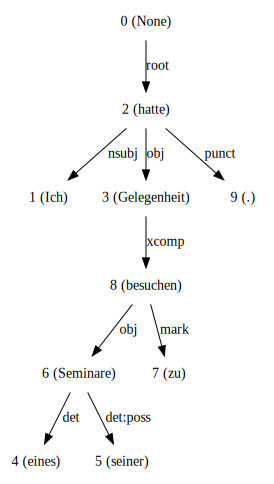

In [142]:
DependencyGraph(d.to_conll(10), top_relation_label="root")

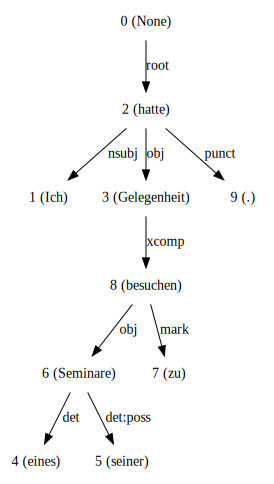

In [103]:
s = sents[1]
s

In [117]:
n = s.get_by_address(0)

In [125]:
s.get_by_address(0)

{'address': 0,
 'ctag': 'TOP',
 'deps': defaultdict(list, {'ROOT': [], 'root': [2]}),
 'feats': None,
 'head': None,
 'lemma': None,
 'rel': None,
 'tag': 'TOP',
 'word': None}

In [112]:
for t in s.triples(n) : print(t)

(('hatte', 'VERB'), 'nsubj', ('Ich', 'PRON'))
(('hatte', 'VERB'), 'obj', ('Gelegenheit', 'NOUN'))
(('Gelegenheit', 'NOUN'), 'xcomp', ('besuchen', 'VERB'))
(('besuchen', 'VERB'), 'obj', ('Seminare', 'NOUN'))
(('Seminare', 'NOUN'), 'det', ('eines', 'DET'))
(('Seminare', 'NOUN'), 'det:poss', ('seiner', 'PRON'))
(('besuchen', 'VERB'), 'mark', ('zu', 'PART'))
(('hatte', 'VERB'), 'punct', ('.', 'PUNCT'))


In [1]:
type(t)

NameError: name 't' is not defined

In [6]:
from nltk.corpus.reader import ConllCorpusReader

In [12]:
#1	Manasse	Manasse	PROPN	NN	Case=Nom|Number=Sing	5	nsubj	_	_
cols = ["ignore", 'ignore', 'words', 'pos', 'ignore', 'ignore', 'tree', 'srl', 'ignore', 'ignore']
conll = ConllCorpusReader("ud-treebanks-conll2017/UD_German", "de-ud-dev.conllx", columntypes=cols)

In [56]:
from nltk.corpus import conll2007

In [57]:
sents = conll2007.sents('esp.train')

In [192]:
head = dep = rel = htag = dtag = []

In [323]:
results = []
for l in ["a", "b", "c", "d", "e"]:
    for n in [1,2,3,4,5,6]:
        if n == 6:
            break
        if n == 4:
            continue
        results.append((l,n))

In [341]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>>,
            {0: {'address': 0,
              'ctag': 'TOP',
              'deps': defaultdict(list, {'root': [2]}),
              'feats': None,
              'head': None,
              'lemma': None,
              'rel': None,
              'tag': 'TOP',
              'word': None},
             1: {'address': 1,
              'ctag': 'NOUN',
              'deps': defaultdict(list, {}),
              'feats': 'Case=Acc|Degree=Pos|Gender=Fem|Number=Sing',
              'head': 2,
              'lemma': 'veritas',
              'rel': 'obj',
              'tag': 'C1|grn1|casD|gen2|vgr1|stAC',
              'word': 'veritatem'},
             2: {'address': 2,
              'ctag': 'VERB',
              'deps': defaultdict(list,
                          {'conj': [9],
                           'nsubj:pass': [3],
                           'obj': [1],
                           'punct': [11]}),


In [346]:
i = 0
for k,v in d.nodes:
    if v["ctag"] == "TOP" or v["ctag"] == "PUNCT":
        continue
    else:
        i += 1

TypeError: 'int' object is not iterable

In [356]:
i

9

In [345]:
print(d.to_conll(10))

1	veritatem	veritas	NOUN	C1|grn1|casD|gen2|vgr1|stAC	Case=Acc|Degree=Pos|Gender=Fem|Number=Sing	2	obj	_	_
2	meditabitur	meditor	VERB	J3|modJ|tem3|gen6|stAC	Mood=Ind|Number=Sing|Person=3|Tense=Fut|VerbForm=Fin|Voice=Pass	0	root	_	_
3	guttur	guttur	NOUN	C1|grn1|casA|gen3|stRS	Case=Nom|Degree=Pos|Gender=Neut|Number=Sing	2	nsubj:pass	_	_
4	meum	meus	DET	F1|grn1|casA|gen3|stPV	Case=Nom|Degree=Pos|Gender=Neut|Number=Sing|Poss=Yes|PronType=Prs	3	det	_	_
5	,	,	PUNCT	Punc	_	9	punct	_	_
6	et	et	CCONJ	O4|stRL	_	9	cc	_	_
7	labia	labium	NOUN	B1|grn1|casJ|gen3|stRS	Case=Nom|Degree=Pos|Gender=Neut|Number=Plur	9	nsubj:pass	_	_
8	mea	meus	DET	F1|grn1|casJ|gen3|stPV	Case=Nom|Degree=Pos|Gender=Neut|Number=Plur|Poss=Yes|PronType=Prs	7	det	_	_
9	detestabuntur	detestor	VERB	J3|modJ|tem3|gen9|stAE	Mood=Ind|Number=Plur|Person=3|Tense=Fut|VerbForm=Fin|Voice=Pass	2	conj	_	_
10	impium	impius	ADJ	B1|grn1|casD|gen3|stAM	Case=Acc|Degree=Pos|Gender=Neut|Number=Sing	9	obj	_	_
11	.	.	PUNCT	Punc	_	2	punct	_	_



In [379]:
countNodes(parsed[100])

9

In [378]:
print(parsed[100].to_conll(10))

1	duplici	duplex	ADJ	C1|grn1|casF|gen2	Case=Abl|Degree=Pos|Gender=Fem|Number=Sing	3	amod	_	_
2	igitur	igitur	ADV	O4|stRL	_	29	advmod	_	_
3	veritate	veritas	NOUN	C1|grn1|casF|gen2|vgr1|stAC	Case=Abl|Degree=Pos|Gender=Fem|Number=Sing	6	nsubj	_	_
4	divinorum	divinus	ADJ	B1|grn1|casK|gen3|stAM	Case=Gen|Degree=Pos|Gender=Neut|Number=Plur	5	amod	_	_
5	intelligibilium	intelligibilis	ADJ	C1|grn1|casK|gen3|stAC	Case=Gen|Degree=Pos|Gender=Neut|Number=Plur	3	amod	_	_
6	existente	existo	VERB	L2|modD|tem1|grp1|casF|gen2|stAV	Case=Abl|Degree=Pos|Gender=Fem|Number=Sing|Tense=Pres|VerbForm=Part|Voice=Act	29	advcl	_	_
7	,	,	PUNCT	Punc	_	8	punct	_	_
8	una	unus	NUM	F1|grn1|casF|gen2	Case=Abl|Degree=Pos|Gender=Fem|Number=Sing|NumType=Card	3	appos	_	_
9	ad	ad	ADP	S4|stRL	AdpType=Prep	10	case	_	_
10	quam	qui	PRON	F1|grn1|casD|gen2|stRL	Case=Acc|Degree=Pos|Gender=Fem|Number=Sing|PronType=Rel	13	obj	_	_
11	rationis	ratio	NOUN	C1|grn1|casB|gen2|vgr1|stAC	Case=Gen|Degree=Pos|Gender=Fem|Number=Sing	12	nmod	_	_
1

In [448]:
df_cooc[list(df_cooc.columns)].head()

,Prec,Seq
0,qui,sum
1,sum,officium
2,officium,sapiens
3,veritas,meditor
4,meditor,guttur


In [455]:
df = df_cooc
filter_col=list(df.columns)

In [458]:
filter_col

['Prec', 'Seq']

In [460]:
newdf = df[filter_col]
newdf["Counts"] = "" * len(newdf)

In [461]:
newdf.head()

,Prec,Seq,Counts
0,qui,sum,
1,sum,officium,
2,officium,sapiens,
3,veritas,meditor,
4,meditor,guttur,


In [570]:
tab = pd.pivot_table(df,index=["Prec","Seq"], aggfunc=len)

In [571]:
newdf = tab.to_frame("Count")

In [572]:
newdf.reset_index(inplace=True)

In [573]:
newdf.head()

,Prec,Seq,Count
0,2-NO-A3---,si,1
1,4-O--------,anima,1
2,4-O--------,quandoque,1
3,4-O--------,semper,1
4,4-O--------,species,1


In [541]:
len(tab)

62900

In [543]:
list(range(0, len(tab)))[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
p = "ud-treebanks-conll2017/UD_Arabic/"

In [14]:
tbname= os.path.split(p.rstrip("/"))[-1]

In [15]:
os.path.join("network_files", tbname)

'network_files/UD_Arabic'

In [42]:
def countEdges(df):
    """Read dataframe and return a new dataframe with counts
    """
    if filter_col == None:
        filter_col = list(df.columns)
    print(filter_col)
    tab = pd.pivot_table(df,index=filter_col, aggfunc=len)
    newdf = tab.to_frame("Count")
    newdf.reset_index(inplace=True)
    return newdf

In [43]:
list(df_dep_lemma.columns)

['Dep_Lemma', 'Head_Lemma', 'Relation']

In [44]:
tab = countEdges(df_dep_lemma)

['Dep_Lemma', 'Head_Lemma', 'Relation']


In [37]:
tab = pd.pivot_table(df_dep_lemma,index=list(df_dep_lemma), aggfunc=len)

In [45]:
df_norel = df_dep_lemma[["Dep_Lemma","Head_Lemma"]]

In [46]:
df_norel.head()

,Dep_Lemma,Head_Lemma
0,telefon,rada
1,na,telefon
2,poradit,potřebovat
3,rychle,poradit
4,telefon,zvednout


In [48]:
unidep.fileids()[0][:2]

'cs'